In [1]:
import numpy as np
import adi
import matplotlib.pyplot as plt

from __future__ import print_function

from pynq import MMIO
import sys
import numpy as np
from time import time
from HCD import Harris_corner_detector
from pynq import Overlay
from pynq import allocate
import cv2
from matplotlib import pyplot as plt
import imageio as iio

sample_rate = 1e6 # Hz
center_freq = 915e6 # Hz
num_samps = 100000 # number of samples per call to rx()

sdr = adi.Pluto("ip:192.168.10.1")
sdr.sample_rate = int(sample_rate)

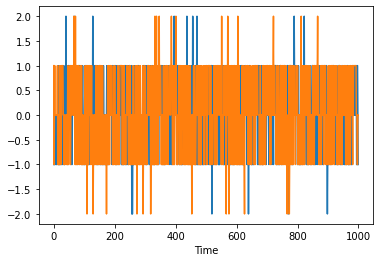

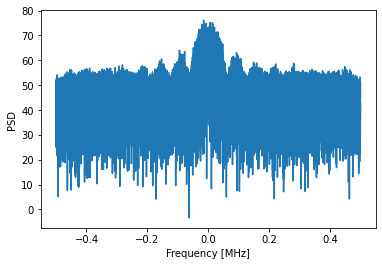

In [2]:
# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -50 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = num_samps
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC


# Create transmit waveform 
num_symbols = 1000
x_int = np.random.randint(0, 4, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
samples = np.repeat(x_symbols, 16) # 16 samples per symbol (rectangular pulses)
samples *= 2**14 # The PlutoSDR expects samples to be between -2^14 and +2^14, not -1 and +1 like some SDRs

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(samples) # start transmitting
#print(samples)

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()
    
# Receive samples
rx_samples = sdr.rx()
#print(rx_samples)


# Calculate power spectral density (frequency domain version of signal)
psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
psd_dB = 10*np.log10(psd)
f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))

# Plot time domain
plt.figure(0)
plt.plot(np.real(rx_samples[::100]))
plt.plot(np.imag(rx_samples[::100]))
plt.xlabel("Time")

# Plot freq domain
plt.figure(1)
plt.plot(f/1e6, psd_dB)
plt.xlabel("Frequency [MHz]")
plt.ylabel("PSD")
plt.show()

In [ ]:

#Beginning of image processing
threshold = 200.0

# read an image
img = cv2.imread("forgery4cats1.png")
#img = cv2.imread('GunCopy.png')
#img = cv2.imread("ex.png")
max_width = 1920
max_height = 1080
                 
img2 = img  
#print(img.shape)

nbytes = img.shape[0] * img.shape[1] * 4

# designate a bitstream to be flashed to the FPGA

ol = Overlay("/home/xilinx/jupyter_notebooks/CapstoneF/design_1.bit") 
ol.download() # flash the FPGA
print ('Overlay Complete')
# mul_ip = MMIO(0x41E00000, 0x10000) # (IP_BASE_ADDRESS, ADDRESS_RANGE), told to us in Vivado

ipHCD = ol.HCD_0
ipDMAIn = ol.axi_dma_0
ipDMAOut = ipDMAIn
inBuffer0 = allocate(shape=(max_width * max_height,), dtype=np.int32)
outBuffer0 = allocate(shape=(max_width * max_height,), dtype=np.int32)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        inBuffer0[i*img.shape[1] + j] = int(img[i][j][0] + (img[i][j][1] << 8) + (img[i][j][2] << 16))

Overlay Complete


In [ ]:
print ('Start Kernel')

timeKernelStart = time()
ipHCD.write(0x10, img.shape[0])
ipHCD.write(0x18, img.shape[1])
ipHCD.write(0x00, 0x01)
ipDMAIn.sendchannel.transfer(inBuffer0, nbytes=nbytes)
ipDMAOut.recvchannel.transfer(outBuffer0, nbytes=nbytes)

print ('End Kernel')
timeKernelEnd = time()

In [ ]:

fig = plt.figure(figsize=(10, 7))
#fig.add_subplot(1, 3, 1)

#print input
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title('Input')

In [ ]:
cpu_start = time()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)
HCD = Harris_corner_detector(threshold)
response = HCD.detect_harris_corners(img_gray)
result = HCD.post_processing(response)
cpu_end = time()
print("CPU rum time:", (cpu_end - cpu_start), "sec")
    
for res in result:
    if res[0] < img.shape[0] - 1:
        if res[1] < img.shape[1] - 1:
            img[res[0]+1, res[1]+1] = [0, 0, 255]
        if res[1] > 0:
            img[res[0]+1, res[1]-1] = [0, 0, 255]
        img[res[0]+1, res[1]] = [0, 0, 255]
    if res[0] > 0:
        if res[1] < img.shape[1] - 1:
            img[res[0]-1, res[1]+1] = [0, 0, 255]
        if res[1] > 0:
            img[res[0]-1, res[1]-1] = [0, 0, 255]
        img[res[0]-1, res[1]] = [0, 0, 255]
    if res[1] < img.shape[1] - 1:
        img[res[0], res[1]+1] = [0, 0, 255]
    if res[1] > 0:
        img[res[0], res[1]-1] = [0, 0, 255]
    img[res[0], res[1]] = [0, 0, 255]
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig.add_subplot(1, 3, 2)
plt.imshow(image_rgb)
plt.title('CPU Result')

In [ ]:
#print kernel result
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if(outBuffer0[i*img.shape[1] + j] == 1):
            img2[i, j] = [0, 0, 255]
image_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 3, 3)
plt.imshow(image_rgb)
plt.title('Kernel Result')
    
plt.show()
      
print("Kernel execution time: " + str(timeKernelEnd - timeKernelStart) + " s")    
print("============================")
print("Exit process")